In [ ]:
import gym
import numpy as np
from scipy.special import softmax
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# **ENVIRONMENTS**

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


# **REINFORCE**

## **FROZEN-LAKE**

In [ ]:
"""
Assume - state represented in one-hot -> 16 states -> each state represented using a feature vector of size 16
s -> shape = (n_states, n_states)
represent state-value function as a linear function of the state
w -> shape = (n_states, )
v(s, w) = np.sum(w * s[i])


Feature vector x(s, a) can be represented as vector of size 6 (n_states, n_actions, n_states * n_actions)
represent policy parameter as a linear function of the feature vector
theta -> shape = (n_states * n_actions, )
h(s, a, theta) = np.sum(theta * x[s, a])
pi[s] = softmax on h along s
"""

In [ ]:
n_states = env.observation_space.n
n_actions = env.action_space.n
n_features = n_states * n_actions

In [ ]:
states = np.zeros((n_states, n_states))
states[np.arange(n_states), np.arange(n_states)] = 1

In [ ]:
feature_vector = np.zeros((n_states, n_actions, n_states * n_actions))
for state in range(n_states): 
  for action in range(n_actions):
    feature_vector[state, action, state * n_actions + action] = 1

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
def get_preferences(state, feature_vector, theta):
  action_preferences = np.sum(feature_vector[state] * theta, axis = 1) # shape: (n_actions)
  return softmax(action_preferences) # shape: (n_actions)

In [ ]:
def choose_action(state, feature_vector, theta):
  pi = get_preferences(state, feature_vector, theta)
  return np.random.choice(np.arange(n_actions), p = pi) # Sample from probability distribution

In [ ]:
def get_state_value(states, state, w):
  return np.sum(states[state] * w)

In [ ]:
def reinforce(num_eps, alpha_w, alpha_theta):
  w = np.zeros(n_states)
  theta = np.zeros(n_states * n_actions)

  total_returns = []
  for ep in tqdm(range(num_eps)):
    # Generate state, action, reward tuples following the given policy
    state = env.reset()
    done = False
    state_action_reward = []
    while not done:
      action = choose_action(state, feature_vector, theta)
      next_state, reward, done, _ = env.step(action)
      state_action_reward.append((state, action, reward))
      state = next_state

    # Improve the policy and value function
    returns = 0
    for state, action, reward in reversed(state_action_reward):
      returns += reward
      delta = returns - get_state_value(states, state, w)

      grad_w = states[state]
      w = w + alpha_w * delta * grad_w

      pi = get_preferences(state, feature_vector, theta)
      grad_theta = feature_vector[state, action] - np.sum([pi[a] * feature_vector[state, a] for a in range(n_actions) if a != action], axis = 0)
      theta = theta + alpha_theta * delta * grad_theta

    total_returns.append(returns)
  return total_returns, w, theta

In [ ]:
"""
Working parameters:
is_slippery = False:
	num_eps = 1000
	alpha_w = 0.005
	alpha_theta = 0.1

is_slippery = True:
	num_eps = 10000
	alpha_w = 0.1
	alpha_theta = 0.05
"""

In [ ]:
alpha_w = 0.1
alpha_theta = 0.05

In [ ]:
num_eps = 10000

In [ ]:
total_returns, w, theta = reinforce(num_eps, alpha_w, alpha_theta)
print(f'Successful Runs: {np.sum(total_returns)}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Successful Runs: 3008.0


In [ ]:
# Map:

# SFFF
# FHFH
# FFFH
# HFFG

In [ ]:
state_values = [[get_state_value(states, i*4 + j, w) for j in range(4)] for i in range(4)]
state_values[3][3] = 1

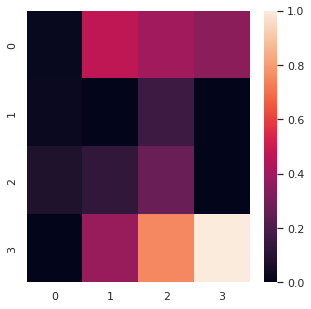

In [ ]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.heatmap(np.round(np.array(state_values), 2))

In [ ]:
rolling_returns = moving_average(total_returns, n = num_eps // 40)
if len(rolling_returns) > 10000: rolling_returns = [rr for i, rr in enumerate(rolling_returns) if i % (num_eps//10000) == 0]

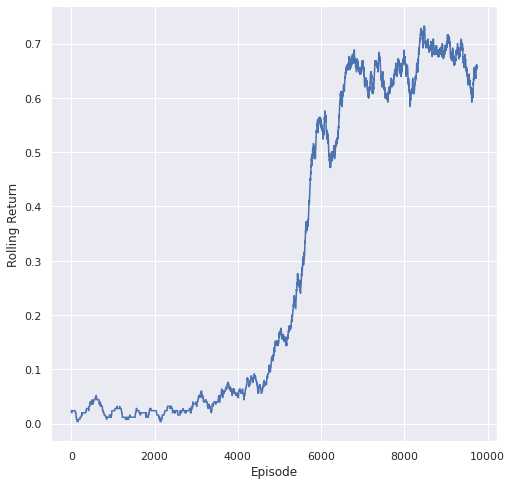

In [ ]:
sns.set(rc={'figure.figsize':(8, 8)})
ax = sns.lineplot(x = np.arange(len(rolling_returns)) + 1, y = rolling_returns)
ax.set(xlabel='Episode', ylabel='Rolling Return')
plt.show()

### **GRID SEARCH**

In [ ]:
alpha_w_range = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1]
alpha_theta_range = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1]

In [ ]:
num_eps = 10000

In [ ]:
performance = []
for alpha_w in alpha_w_range:
  for alpha_theta in alpha_theta_range:
    print(f'Alpha-W: {alpha_w}, Alpha-Theta: {alpha_theta}')
    total_returns, w, theta = reinforce(num_eps, alpha_w, alpha_theta)
    performance.append((alpha_w, alpha_theta, total_returns))

Alpha-W: 0.001, Alpha-Theta: 0.001


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.001, Alpha-Theta: 0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.001, Alpha-Theta: 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.001, Alpha-Theta: 0.025


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.001, Alpha-Theta: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.001, Alpha-Theta: 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.005, Alpha-Theta: 0.001


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.005, Alpha-Theta: 0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.005, Alpha-Theta: 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.005, Alpha-Theta: 0.025


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.005, Alpha-Theta: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.005, Alpha-Theta: 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.01, Alpha-Theta: 0.001


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.01, Alpha-Theta: 0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.01, Alpha-Theta: 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.01, Alpha-Theta: 0.025


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.01, Alpha-Theta: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.01, Alpha-Theta: 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.025, Alpha-Theta: 0.001


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.025, Alpha-Theta: 0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.025, Alpha-Theta: 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.025, Alpha-Theta: 0.025


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.025, Alpha-Theta: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.025, Alpha-Theta: 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.05, Alpha-Theta: 0.001


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.05, Alpha-Theta: 0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.05, Alpha-Theta: 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.05, Alpha-Theta: 0.025


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.05, Alpha-Theta: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.05, Alpha-Theta: 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.1, Alpha-Theta: 0.001


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.1, Alpha-Theta: 0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.1, Alpha-Theta: 0.01


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.1, Alpha-Theta: 0.025


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.1, Alpha-Theta: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

Alpha-W: 0.1, Alpha-Theta: 0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
for alpha_w, alpha_theta, total_returns in performance:
  print(f'Alpha-W: {alpha_w}, Alpha-Theta: {alpha_theta}, Total Returns: {np.sum(total_returns)},Last 1000: {np.sum(total_returns[-1000:])}')

Alpha-W: 0.001, Alpha-Theta: 0.001, Total Returns: 152.0,Last 1000: 14.0
Alpha-W: 0.001, Alpha-Theta: 0.005, Total Returns: 135.0,Last 1000: 17.0
Alpha-W: 0.001, Alpha-Theta: 0.01, Total Returns: 178.0,Last 1000: 21.0
Alpha-W: 0.001, Alpha-Theta: 0.025, Total Returns: 604.0,Last 1000: 331.0
Alpha-W: 0.001, Alpha-Theta: 0.05, Total Returns: 1860.0,Last 1000: 297.0
Alpha-W: 0.001, Alpha-Theta: 0.1, Total Returns: 4460.0,Last 1000: 644.0
Alpha-W: 0.005, Alpha-Theta: 0.001, Total Returns: 144.0,Last 1000: 21.0
Alpha-W: 0.005, Alpha-Theta: 0.005, Total Returns: 153.0,Last 1000: 14.0
Alpha-W: 0.005, Alpha-Theta: 0.01, Total Returns: 178.0,Last 1000: 21.0
Alpha-W: 0.005, Alpha-Theta: 0.025, Total Returns: 261.0,Last 1000: 67.0
Alpha-W: 0.005, Alpha-Theta: 0.05, Total Returns: 2415.0,Last 1000: 532.0
Alpha-W: 0.005, Alpha-Theta: 0.1, Total Returns: 1770.0,Last 1000: 244.0
Alpha-W: 0.01, Alpha-Theta: 0.001, Total Returns: 144.0,Last 1000: 13.0
Alpha-W: 0.01, Alpha-Theta: 0.005, Total Returns: 1